<a href="https://colab.research.google.com/github/dm-fedorov/pandas_basic/blob/master/%D0%BA%D0%B5%D0%B9%D1%81%D1%8B%20%D0%BF%D0%BE%20%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D1%83%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85/%D0%B7%D0%B0%D1%80%D0%BF%D0%BB%D0%B0%D1%82%D1%8B%20%D0%B2%20%D0%98%D0%A2.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

В качестве примера взглянем на находящиеся в открытом доступе данные о рождаемости в США, предоставляемые центрами по контролю заболеваний (Centers for Disease Control, CDC):

In [2]:
import pandas as pd
import numpy as np

Посмотрев на эти данные, мы обнаружим их относительную простоту — они содержат количество новорожденных, сгруппированных по дате и полу:

In [3]:
births = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv')
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


Мы начнем понимать эти данные немного лучше, воспользовавшись сводной таблицей. Добавим в них столбец для десятилетия и взглянем на рождения девочек и мальчиков как функцию от десятилетия:

In [4]:
births['decade'] = 10 * (births['year'] // 10)
births['decade']

0        1960
1        1960
2        1960
3        1960
4        1960
         ... 
15542    2000
15543    2000
15544    2000
15545    2000
15546    2000
Name: decade, Length: 15547, dtype: int64

In [5]:
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


Сразу же видим, что в каждом десятилетии мальчиков рождается больше, чем девочек. Воспользуемся встроенными средствами построения графиков библиотеки Pandas для визуализации общего количества новорожденных в зависимости от года:

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Используем стили библиотеки Seaborn

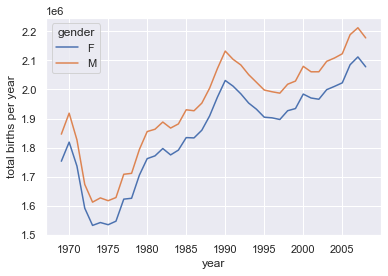

In [8]:
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year'); # общее количество новорожденных в течение года

Благодаря сводной таблице и методу plot() мы можем сразу же увидеть ежегодный тренд новорожденных по полу. В последние 50 с лишним лет мальчиков рождалось больше, чем девочек, примерно на 5 %.

Хотя это, возможно, и не имеет отношения к сводным таблицам, есть еще несколько интересных вещей, которые можно извлечь из этого набора данных с помощью уже рассмотренных инструментов библиотеки Pandas. Нам придется начать с небольшой очистки данных, удалив аномальные значения, возникшие из-за неправильно набранных дат (например,
31 июня) или отсутствующих значений (например, 99 июня). Простой способ убрать сразу их все — отсечь аномальные значения. Мы сделаем это с помощью надежного алгоритма сигма-отсечения ([sigma-clipping](https://docs.astropy.org/en/stable/stats/robust.html#sigma-clipping)):

In [9]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

Последняя строка представляет собой грубую оценку среднего значения выборки, в котором 0.74 — межквартильный размах Гауссового распределения. Теперь можно воспользоваться методом query() для фильтрации строк, в которых количество новорожденных выходит за пределы этих значений:

In [10]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

Далее мы устанавливаем целочисленный тип столбца для day . Ранее он был строчным, поскольку некоторые столбцы в наборе данных содержат значение 'null' :

In [11]:
births['day'] = births['day'].astype(int)

Наконец, мы можем создать индекс для даты, объединив день, месяц и год. Это даст нам возможность быстро вычислять день недели для каждой строки:

In [12]:
# создаем индекс для даты из года, месяца и дня

births.index = pd.to_datetime(10000 * births.year + 100 * births.month + births.day, format='%Y%m%d')
births['dayofweek'] = births.index.dayofweek # День недели

С помощью этого можно построить график дней рождения в зависимости от дня недели за несколько десятилетий

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

<ipython-input-14-8c625a2d33e3>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])


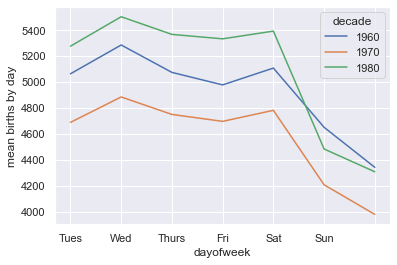

In [14]:
births.pivot_table('births', index='dayofweek', columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day'); # среднее количество новорожденных в день

Становится очевидно, что в выходные происходит меньше рождений, чем в будние дни! Обратите внимание, что 1990-е и 2000-е годы отсутствуют на графике, поскольку начиная с 1989 года данные CDC содержат только месяц рождения.
Еще одно интересное представление этих данных можно получить, построив график рождений в зависимости от дня года. Сначала сгруппируем данные отдельно по месяцу и дню:

In [15]:
births_by_date = births.pivot_table('births', [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

Результат представляет собой мультииндекс по месяцам и дням. Чтобы упростить построение графика, преобразуем эти месяцы и дни в даты путем связывания их с фиктивным годом (обязательно выберите високосный год, чтобы обработать 29 февраля корректным образом!)

In [16]:
births_by_date.index = [pd.datetime(2012, month, day) for (month, day) in births_by_date.index]
births_by_date.head()

<ipython-input-16-9a4d11c966ab>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_by_date.index = [pd.datetime(2012, month, day) for (month, day) in births_by_date.index]


,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Если смотреть только на месяц и день, то мы получаем временной ряд, отражающий среднее количество новорожденных в зависимости от дня года. Исходя из этого, мы можем построить с помощью метода plot график данных. В нем мы обнаруживаем некоторые любопытные тренды:

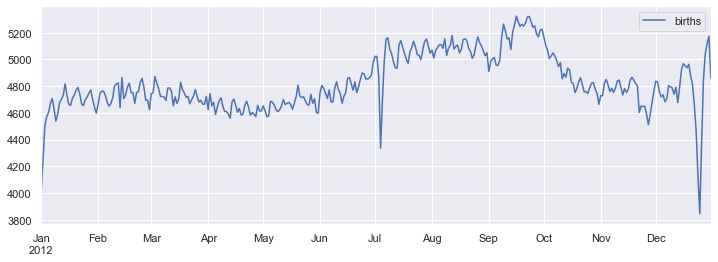

In [17]:
# Строим график результатов
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

В частности, на графике удивляет резкое падение количества рождений в государственные праздники США (например, День независимости, День труда, День благодарения, Рождество, Новый год). Хотя оно отражает скорее тенденции,
относящиеся к заранее запланированным/искусственным родам, а не глубокое психосоматическое влияние на естественные роды. 

Дальнейшее обсуждение данной тенденции, ее анализ и ссылки на эту тему смотрите в [сообщении](https://statmodeling.stat.columbia.edu/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/) из блога Эндрю Гелмана. 